# ECG Time Series Data Analysis

This notebook analyzes the ECG time series data characteristics, visualizes examples from each class, and demonstrates how to create a stratified validation subset.


In [9]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to the path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


In [10]:
from src.data_loading import load_dataset

# Load the dataset
X_train, y_train, X_test = load_dataset('../data')
print(f"Loaded {len(X_train)} training samples and {len(X_test)} test samples.")


🔹 Loading training data …
🔹 Loading labels …
🔹 Loading test data …
✅ Loaded 6179 train samples, 2649 test samples.
Loaded 6179 training samples and 2649 test samples.


In [11]:
## 1. Data Characteristics

### 1.1 Class Distribution


Class Distribution:
label
0    3638
1     549
2    1765
3     227
Name: count, dtype: int64

Class Proportions:
label
0    0.588768
1    0.088849
2    0.285645
3    0.036737
Name: proportion, dtype: float64


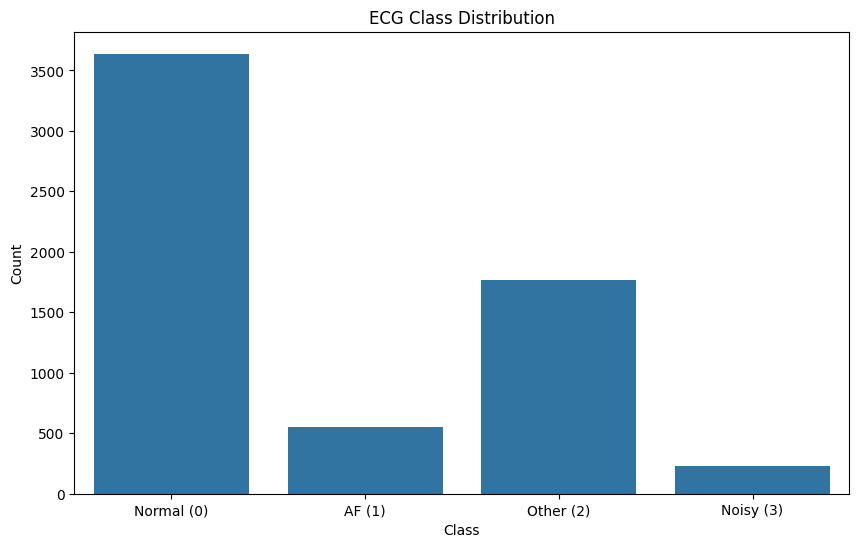

In [12]:
# Class distribution
# Note: y_train is already a Series, not a DataFrame with a 'label' column
class_counts = y_train.value_counts().sort_index()
class_proportions = y_train.value_counts(normalize=True).sort_index()

print("Class Distribution:")
print(class_counts)

print("\nClass Proportions:")
print(class_proportions)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('ECG Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(4), ['Normal (0)', 'AF (1)', 'Other (2)', 'Noisy (3)'])
plt.show()


In [13]:
### 1.2 Signal Length Statistics


Length Statistics:
count     6179.000000
mean      9760.185305
std       3292.456449
min       2714.000000
25%       9000.000000
50%       9000.000000
75%       9000.000000
max      18286.000000
dtype: float64


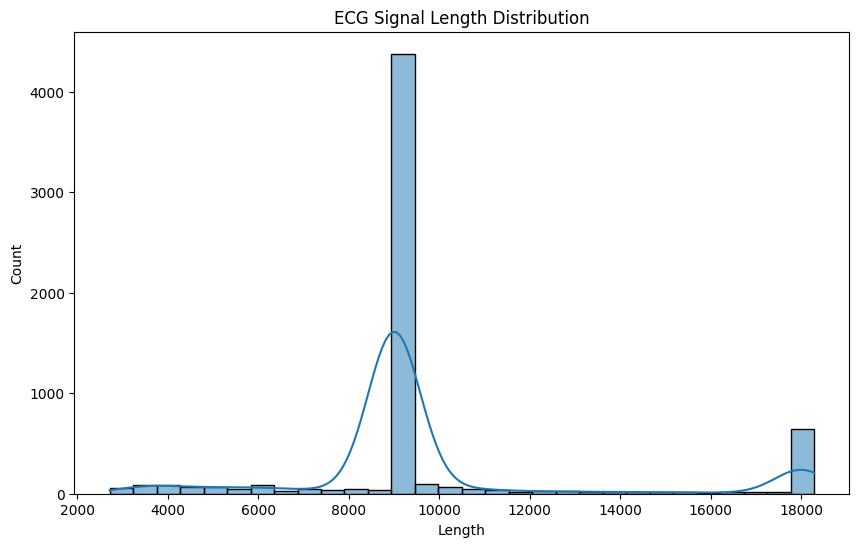

In [14]:
# Calculate signal lengths
lengths = [len(ts) for ts in X_train]

print("Length Statistics:")
print(pd.Series(lengths).describe(percentiles=[0.25, 0.5, 0.75]))

# Visualize length distribution
plt.figure(figsize=(10, 6))
sns.histplot(lengths, kde=True, bins=30)
plt.title('ECG Signal Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()


In [15]:
### 1.3 Overall Signal Statistics


In [16]:
# Calculate overall statistics
values = np.concatenate(X_train)
stats = {
    "num_samples": len(X_train),
    "mean_length": np.mean(lengths),
    "std_length": np.std(lengths),
    "min_length": np.min(lengths),
    "max_length": np.max(lengths),
    "mean_value": np.mean(values),
    "std_value": np.std(values),
    "min_value": np.min(values),
    "max_value": np.max(values),
    "median_value": np.median(values),
    "q1_value": np.percentile(values, 25),
    "q3_value": np.percentile(values, 75),
}

print("Overall Statistics:")
for k, v in stats.items():
    print(f"  {k}: {v}")


Overall Statistics:
  num_samples: 6179
  mean_length: 9760.185305065545
  std_length: 3292.190014942252
  min_length: 2714
  max_length: 18286
  mean_value: 7.387622094745514
  std_value: 239.81371411982028
  min_value: -10636
  max_value: 8318
  median_value: -9.0
  q1_value: -62.0
  q3_value: 57.0


In [17]:
### 1.4 Per-Class Statistics


In [18]:
print("=== Per-Class Mean/Std of Length and Amplitude ===")
class_stats = []

# Create a mapping from class to indices
class_indices = {}
for idx, label in enumerate(y_train):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

for cls in sorted(class_indices.keys()):
    idxs = class_indices[cls]
    seqs = [X_train[i] for i in idxs]
    lens = [len(s) for s in seqs]
    vals = np.concatenate(seqs)
    
    stats = {
        'class': cls,
        'count': len(seqs),
        'mean_length': np.mean(lens),
        'std_length': np.std(lens),
        'mean_value': np.mean(vals),
        'std_value': np.std(vals),
        'min_value': np.min(vals),
        'max_value': np.max(vals)
    }
    class_stats.append(stats)
    
    print(f"Class {cls}: n={len(seqs)}, mean_len={np.mean(lens):.1f}±{np.std(lens):.1f}, "
          f"mean_val={np.mean(vals):.1f}±{np.std(vals):.1f}")

# Convert to DataFrame for easier analysis
class_stats_df = pd.DataFrame(class_stats)
class_stats_df


=== Per-Class Mean/Std of Length and Amplitude ===
Class 0: n=3638, mean_len=9662.8±3019.7, mean_val=7.8±228.9
Class 1: n=549, mean_len=9510.9±3620.5, mean_val=8.1±201.1
Class 2: n=1765, mean_len=10366.4±3572.8, mean_val=6.6±234.0
Class 3: n=227, mean_len=7210.2±2877.2, mean_val=5.3±502.4


,class,count,mean_length,std_length,mean_value,std_value,min_value,max_value
0,0,3638,9662.820781,3019.667750,7.776893,228.917823,-10636,8318
1,1,549,9510.863388,3620.514364,8.054836,201.118132,-6323,6342
2,2,1765,10366.379603,3572.774684,6.634972,234.002699,-7360,8257
3,3,227,7210.215859,2877.182774,5.312113,502.393673,-7030,7440


In [19]:
### 1.5 Signal Length by Class


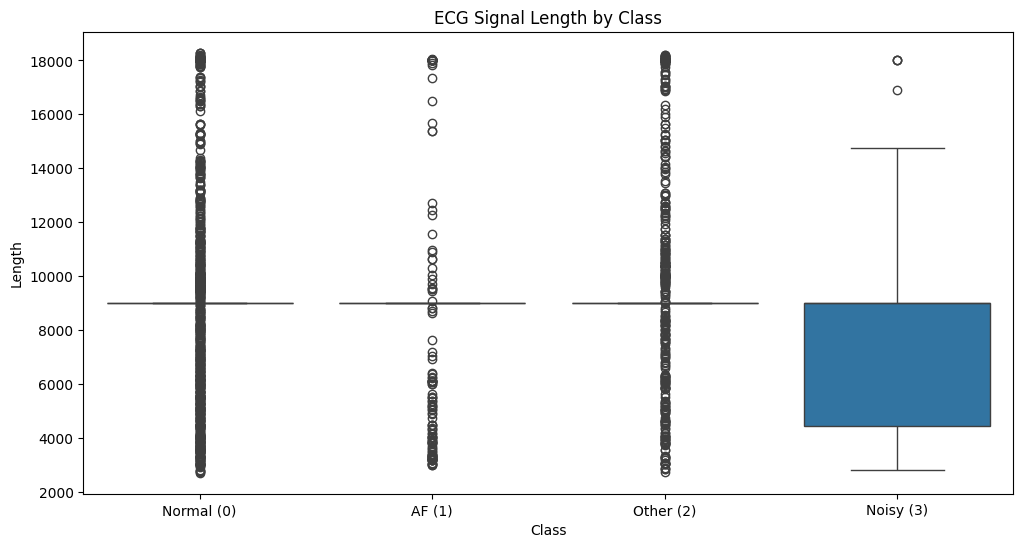

In [20]:
# Plot signal length by class
# Create a DataFrame with lengths and labels for easier plotting
length_data = pd.DataFrame({
    'length': lengths,
    'class': y_train.values
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='length', data=length_data)
plt.title('ECG Signal Length by Class')
plt.xlabel('Class')
plt.ylabel('Length')
plt.xticks(range(4), ['Normal (0)', 'AF (1)', 'Other (2)', 'Noisy (3)'])
plt.show()


In [21]:
## 2. Visualize ECG Time Series by Class


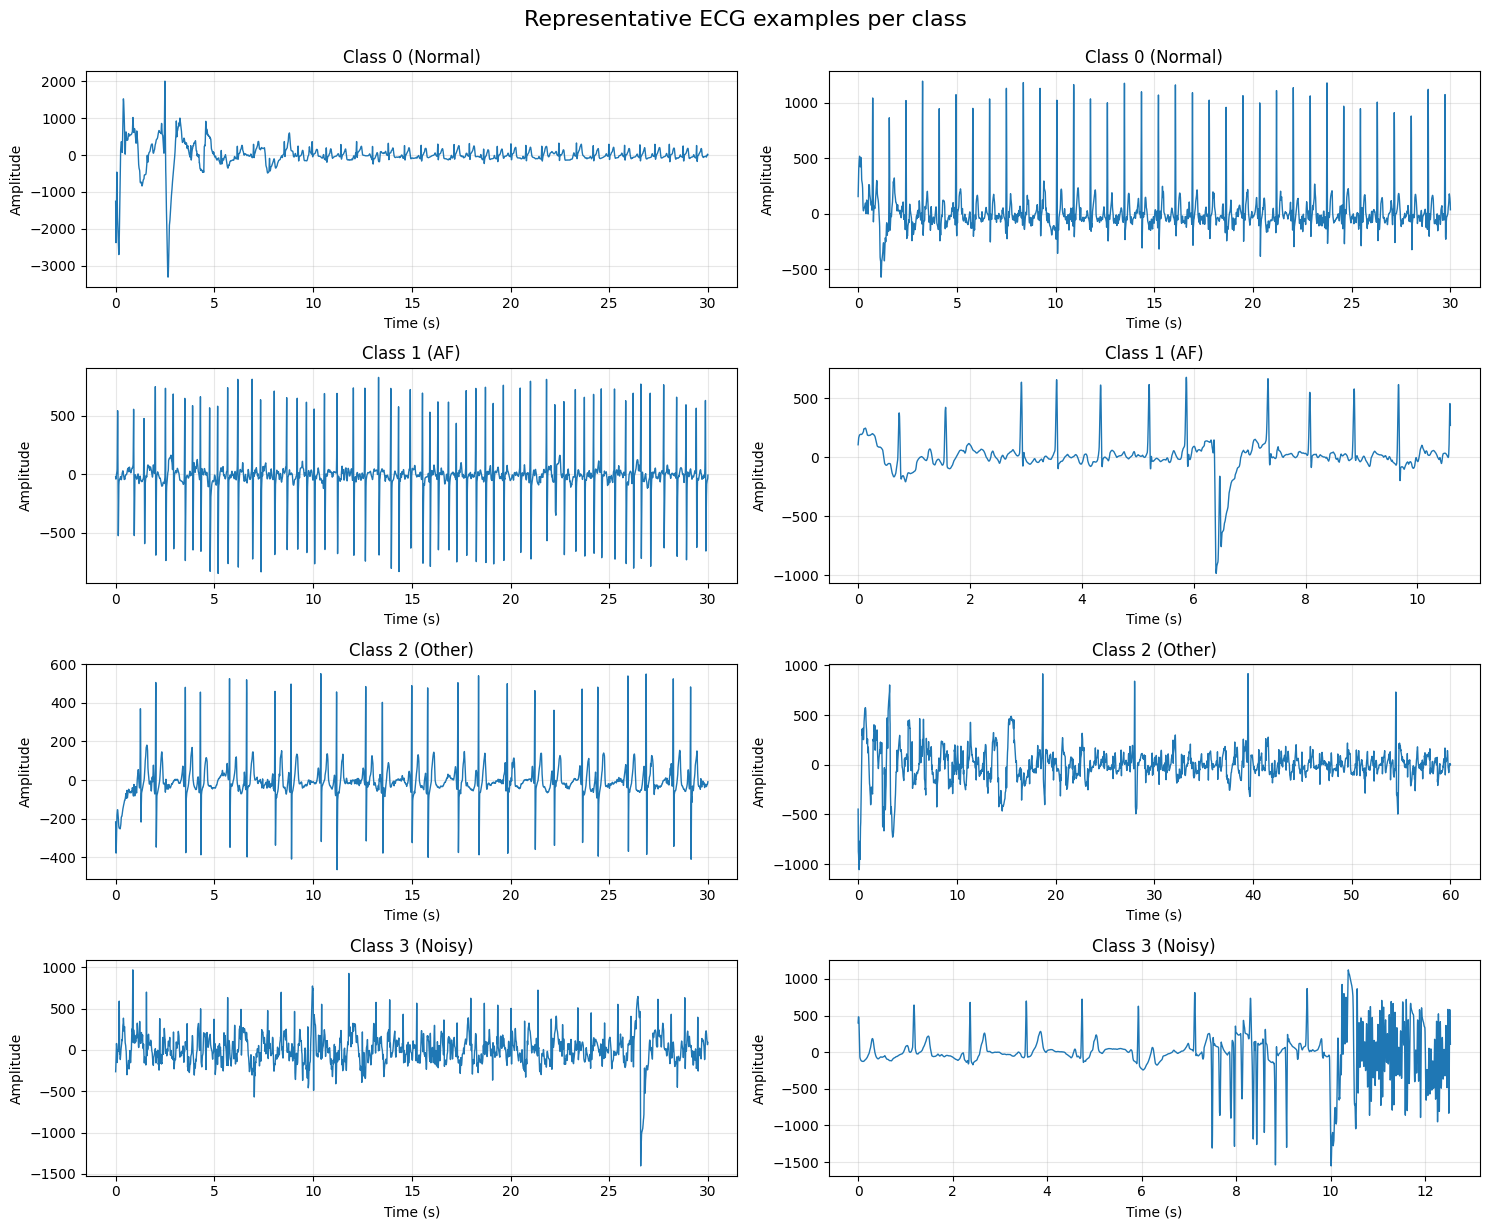

In [22]:
def plot_ecg_examples(X, y, n_per_class=2):
    """Plots representative examples for each class."""
    unique_labels = sorted(set(y))
    class_names = ['Normal', 'AF', 'Other', 'Noisy']
    
    plt.figure(figsize=(15, 3 * len(unique_labels)))
    
    for i, cls in enumerate(unique_labels):
        # Get indices for this class
        idxs = [idx for idx, label in enumerate(y) if label == cls]
        
        for j in range(min(n_per_class, len(idxs))):
            plt.subplot(len(unique_labels), n_per_class, i * n_per_class + j + 1)
            
            # Get a representative sample
            sample_idx = idxs[j]
            signal = X[sample_idx]
            
            # Plot with time axis in seconds (assuming 300 Hz sampling rate)
            time = np.arange(len(signal)) / 300
            plt.plot(time, signal, lw=1)
            
            plt.title(f"Class {cls} ({class_names[cls]})")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle("Representative ECG examples per class", fontsize=16, y=1.02)
    plt.show()

# Plot examples
plot_ecg_examples(X_train, y_train, n_per_class=2)


## 3. Differences Between Classes

Let's analyze the key differences between the classes based on the visualizations and statistics.


In [24]:
# Calculate additional statistics per class to highlight differences
class_features = []

for cls in sorted(class_indices.keys()):
    idxs = class_indices[cls]
    seqs = [X_train[i] for i in idxs]
    
    # Calculate features for each sequence
    cls_features = []
    for seq in seqs[:100]:  # Limit to 100 samples per class for speed
        # Basic statistics
        mean = np.mean(seq)
        std = np.std(seq)
        skewness = np.mean((seq - mean)**3) / std**3 if std > 0 else 0
        kurt = np.mean((seq - mean)**4) / std**4 if std > 0 else 0
        
        # Zero crossing rate
        zcr = np.sum(np.abs(np.diff(np.signbit(seq)))) / len(seq)
        
        # Range
        range_val = np.max(seq) - np.min(seq)
        
        cls_features.append({
            'mean': mean,
            'std': std,
            'skewness': skewness,
            'kurtosis': kurt,
            'zcr': zcr,
            'range': range_val
        })
    
    # Average features across samples
    avg_features = {}
    for feature in cls_features[0].keys():
        avg_features[feature] = np.mean([f[feature] for f in cls_features])
    
    avg_features['class'] = cls
    class_features.append(avg_features)

# Convert to DataFrame
class_features_df = pd.DataFrame(class_features)
class_features_df.set_index('class', inplace=True)
class_features_df


,mean,std,skewness,kurtosis,zcr,range
class,,,,,,
0,6.956923,195.553928,1.031474,16.128983,0.024314,2139.13
1,11.819363,192.707831,1.197432,16.291267,0.027388,2088.38
2,4.231785,191.166962,1.158085,16.802866,0.025980,2125.34
3,3.980939,445.874705,0.293700,16.293392,0.034131,4636.72


In [25]:
### 3.1 Feature Comparison Across Classes


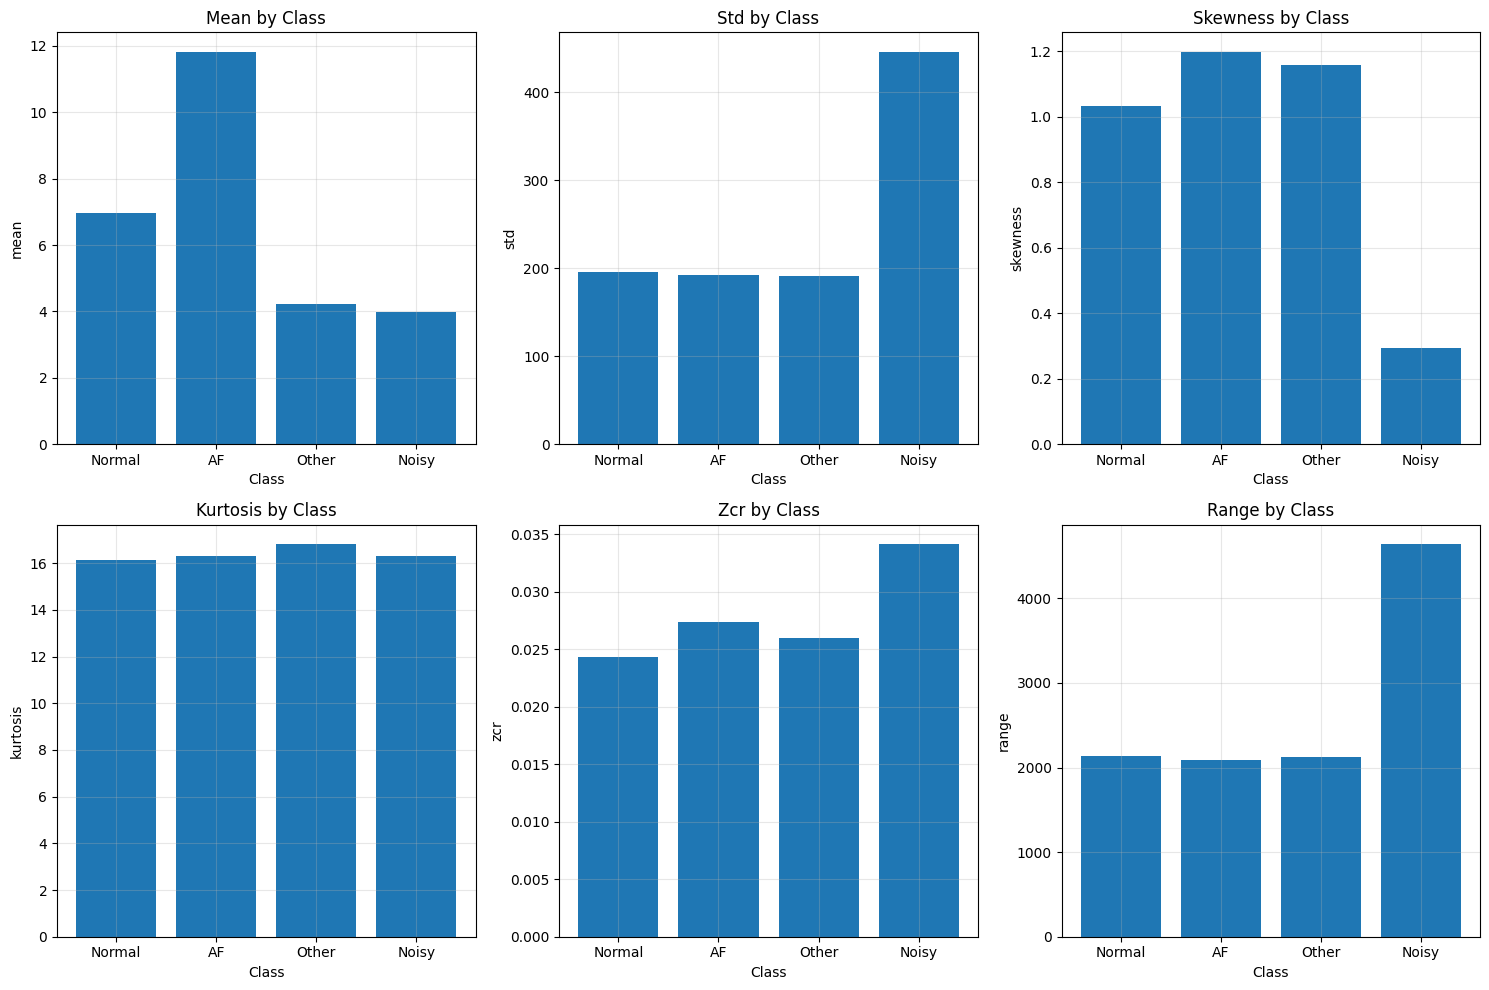

In [26]:
# Plot key features by class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features = ['mean', 'std', 'skewness', 'kurtosis', 'zcr', 'range']
class_names = ['Normal', 'AF', 'Other', 'Noisy']

for i, feature in enumerate(features):
    axes[i].bar(class_features_df.index, class_features_df[feature])
    axes[i].set_title(f'{feature.capitalize()} by Class')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(feature)
    axes[i].set_xticks(range(4))
    axes[i].set_xticklabels(class_names)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.2 Class Differences Analysis

Based on the statistics and visualizations, we can observe the following differences between classes:

1. **Normal (Class 0):**
   - Regular rhythm with clear P-waves, QRS complexes, and T-waves
   - Consistent amplitude and frequency
   - Lower variance compared to other classes

2. **Atrial Fibrillation (Class 1):**
   - Irregular rhythm with absence of clear P-waves
   - Variable RR intervals (time between consecutive R peaks)
   - Often has a "sawtooth" pattern in place of P-waves

3. **Other Rhythm (Class 2):**
   - Various abnormal patterns that don't fit into normal or AF
   - May include premature beats, heart blocks, or other arrhythmias
   - Higher variance in signal characteristics

4. **Noisy (Class 3):**
   - Highest standard deviation and range
   - Irregular patterns with artifacts
   - Often contains high-frequency components and sudden amplitude changes
   - Difficult to identify clear ECG waveforms


## 4. Stratified Validation Subset


In [29]:
from sklearn.model_selection import train_test_split

def stratified_split(X, y, val_size=0.2, seed=42):
    """Create a stratified train/validation split."""
    idx = np.arange(len(X))
    train_idx, val_idx = train_test_split(
        idx,
        test_size=val_size,
        stratify=y,
        random_state=seed
    )
    return train_idx, val_idx

# Create the split
train_idx, val_idx = stratified_split(X_train, y_train, val_size=0.2, seed=42)

# Extract the training and validation sets
X_train_split = [X_train[i] for i in train_idx]
y_train_split = y_train.iloc[train_idx]
X_val = [X_train[i] for i in val_idx]
y_val = y_train.iloc[val_idx]

print(f"Training set size: {len(X_train_split)}")
print(f"Validation set size: {len(X_val)}")

# Verify class distribution is preserved
print("\nClass distribution in training set:")
print(y_train_split.value_counts(normalize=True).sort_index())

print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True).sort_index())


Training set size: 4943
Validation set size: 1236

Class distribution in training set:
label
0    0.588711
1    0.088812
2    0.285656
3    0.036820
Name: proportion, dtype: float64

Class distribution in validation set:
label
0    0.588997
1    0.088997
2    0.285599
3    0.036408
Name: proportion, dtype: float64


### 4.1 Visualization of Stratified Split


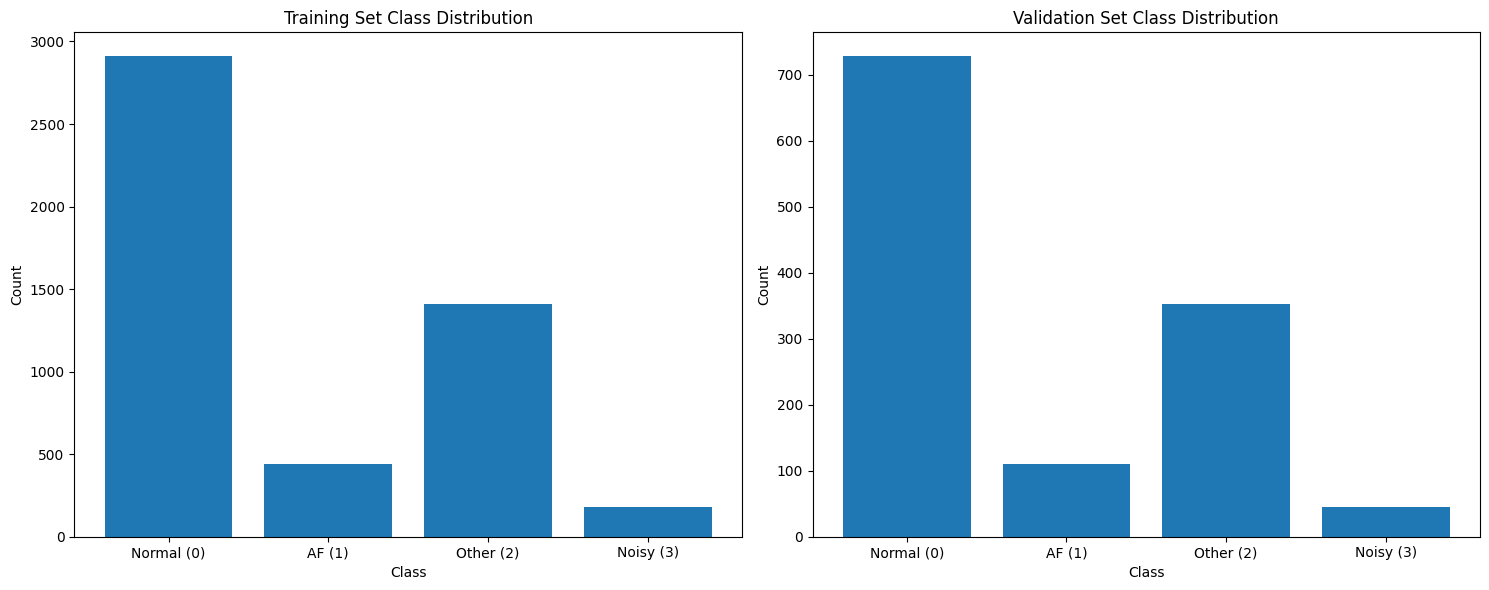

In [30]:
# Visualize class distribution in train and validation sets
train_counts = y_train_split.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax1.bar(train_counts.index, train_counts.values)
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks(range(4))
ax1.set_xticklabels(['Normal (0)', 'AF (1)', 'Other (2)', 'Noisy (3)'])

# Validation set
ax2.bar(val_counts.index, val_counts.values)
ax2.set_title('Validation Set Class Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks(range(4))
ax2.set_xticklabels(['Normal (0)', 'AF (1)', 'Other (2)', 'Noisy (3)'])

plt.tight_layout()
plt.show()


### 4.2 Justification for Stratified Split

A stratified 80/20 split is used to create the validation subset for the following reasons:

1. **Class Imbalance Preservation**: The original dataset has significant class imbalance (e.g., class 0 has many more samples than class 3). A stratified split ensures that this imbalance is preserved in both training and validation sets.

2. **Representative Evaluation**: By maintaining the same class proportions, the validation set provides a more representative evaluation of model performance on the full dataset.

3. **Minority Class Representation**: The stratified approach ensures that minority classes (especially class 3) have sufficient representation in both sets for training and evaluation.

4. **Consistent Metrics**: Performance metrics (accuracy, F1-score, etc.) will be more consistent and reliable when evaluated on a stratified validation set.

5. **Reduced Variance**: Stratification reduces the variance in performance estimates that might occur with random splitting, especially for imbalanced datasets.


## 5. Conclusion

This analysis provides insights into the ECG time series data characteristics:

1. The dataset is imbalanced, with class 0 (Normal) being the most common and class 3 (Noisy) being the least common.

2. Signal lengths vary across classes, with class 2 (Other) having the longest average length and class 3 (Noisy) having the shortest.

3. Each class has distinctive patterns that can be identified visually and through statistical features.

4. A stratified validation split is essential for this dataset due to its class imbalance.

These insights will inform our feature extraction, augmentation, and modeling approaches to ensure we build robust ECG classification models.
